In [1]:
from random import Random

import numpy as np
import pandas as pd
import os

from tqdm import tqdm as tqdm
from torch.utils.data import Dataset
import sklearn
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import umap.umap_ as umap
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Path to the .npz file
DATASET_PATH = "../MLPC2025_classification"

ANNOTATIONS_PATH = DATASET_PATH + "/annotations.csv"
#ANNOTATIONS_TEXT_EMBEDDINGS_PATH = DATASET_PATH + "/annotations_text_embeddings.npz"

METADATA_PATH = DATASET_PATH + "/metadata.csv"
#METADATA_TITLE_EMBEDDINGS_PATH = DATASET_PATH + "/metadata_title_embeddings.npz"
#METADATA_KEYWORDS_EMBEDDINGS_PATH = DATASET_PATH + "/metadata_keywords_embeddings.npz"

AUDIO_PATHS = DATASET_PATH + "/audio"
AUDIO_FEATURES_PATHS = DATASET_PATH + "/audio_features"

LABELS_PATH = DATASET_PATH + "/labels"

In [3]:
annotations = pd.read_csv(ANNOTATIONS_PATH)
annotations.head()

,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
0,161976549,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing loudly and repeatedly nearby.,0.000000,10.503064,345.033,Raw loud alarm sound repeatedly ringing nearby,['Alarm']
1,161976549,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing repeatedly nearby.,12.514616,23.048000,345.033,Clean alarm sound repeatedly ringing nearby,['Alarm']
2,161976550,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,0.000000,13.414880,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
3,161976550,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,15.134252,28.492000,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']"
4,161976551,119173.mp3,8105077500224920444298835829881210427871190692...,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']"


In [4]:
# Remove unnecessary columns for this task
annotations = annotations.drop(columns=['task_id'])
annotations['original_index'] = annotations.index
annotations.head()

,filename,annotator,text,onset,offset,time,original_caption,categories,original_index
0,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing loudly and repeatedly nearby.,0.000000,10.503064,345.033,Raw loud alarm sound repeatedly ringing nearby,['Alarm'],0
1,117126.mp3,1145579747015607221221744067969991550764671773...,An alarm is ringing repeatedly nearby.,12.514616,23.048000,345.033,Clean alarm sound repeatedly ringing nearby,['Alarm'],1
2,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,0.000000,13.414880,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']",2
3,118234.mp3,5022633589939139634134314703519782680423201448...,An alarm clock is beeping continuously.,15.134252,28.492000,919.016,Alarm clock beeping continuesly,"['Alarm', 'Beep/Bleep']",3
4,119173.mp3,8105077500224920444298835829881210427871190692...,A car alarm sounds loudly in a steady pattern.,0.000000,20.065604,2162.620,a car alarm sounds loudly in a steady pattern ...,"['Alarm', 'Car']",4


In [5]:
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,filename,keywords,freesound_id,sound_link,manufacturer,license,title,description,num_downloads,geotag,start_time_s,end_time_s
0,321771.mp3,"Interior, AMB, Italy, Distant, Speech, Reverb",321771,https://freesound.org/people/Skjor1/sounds/321...,Skjor1,http://creativecommons.org/publicdomain/zero/1.0/,Interior Ambience + Distant Reverberant Speech...,Interior Ambience + Distant Reverberant Speech...,120,NaN,5.200,27.179
1,451371.mp3,"kids, throaty, crowd, India, distant, traffic,...",451371,https://freesound.org/people/kyles/sounds/451371/,kyles,http://creativecommons.org/publicdomain/zero/1.0/,election rally crowd and speech with distant t...,election rally crowd and speech with distant t...,122,NaN,120.800,144.984
2,199414.mp3,"broadcast, speech, radio",199414,https://freesound.org/people/martinimeniscus/s...,martinimeniscus,http://creativecommons.org/publicdomain/zero/1.0/,"Old Radio Speech Background, higher FF125.aif",Background noise for an old radio broadcast sp...,391,NaN,102.003,130.921
3,410952.mp3,"loop2017, atmos, dolby, speech, ableton",410952,https://freesound.org/people/lietoofine/sounds...,lietoofine,https://creativecommons.org/licenses/by/4.0/,dolby atmos speech.wav,dolby atmos speech @Loop2017,193,52.479543 13.500279,31.330,54.021
4,203908.mp3,"dr-40, project, speech, student, italian, reci...",203908,https://freesound.org/people/s9ames/sounds/203...,s9ames,http://creativecommons.org/licenses/by/3.0/,bologna speech Italian2,recorded with a tascam dr-40 in a sound studio...,526,NaN,29.200,45.689


In [6]:
# Remove unnecessary columns for this task
metadata = metadata.drop(columns=['freesound_id', 'sound_link', 'manufacturer', 'license', 'num_downloads', 'geotag', 'start_time_s', 'end_time_s'])
metadata.head()

,filename,keywords,title,description
0,321771.mp3,"Interior, AMB, Italy, Distant, Speech, Reverb",Interior Ambience + Distant Reverberant Speech...,Interior Ambience + Distant Reverberant Speech...
1,451371.mp3,"kids, throaty, crowd, India, distant, traffic,...",election rally crowd and speech with distant t...,election rally crowd and speech with distant t...
2,199414.mp3,"broadcast, speech, radio","Old Radio Speech Background, higher FF125.aif",Background noise for an old radio broadcast sp...
3,410952.mp3,"loop2017, atmos, dolby, speech, ableton",dolby atmos speech.wav,dolby atmos speech @Loop2017
4,203908.mp3,"dr-40, project, speech, student, italian, reci...",bologna speech Italian2,recorded with a tascam dr-40 in a sound studio...


Idea for splitting the data:

Use some fixed percentages for training, validation, and test sets (e.g., 70% training, 15% validation, 15% test).
Then, for each label, ensure that the same percentage of files is allocated to each set. This way, you maintain the label distribution across all sets.

Additionally, some resampling (e.g. SMOTE), undersampling (e.g. RUS, TOMEK) or class weighting techniques can be applied to maintain balance during training.

In [7]:
class AudioClassificationDataset(Dataset):

    def __init__(self, data_dir, audio_features_subset, return_snippets, context_length, testing, testing_percentage):
        """
        data_dir: Path to the dataset directory
        audio_features_subset: List of audio features to be used
        return_snippets: If False, return whole files, if True, return snippets of size context_length
        context_length: Length of the snippets to be returned (ideally uneven number)
        testing: If True, use a small subset of the audio files for testing
        """

        self.return_snippets = return_snippets
        self.context_length = context_length

        audio_path = os.path.join(data_dir, 'audio')

        # For testing purposes, use a smaller subset of the audio files (just copy some audio files from the audio directory
        # to a new directory at the same level)
        #audio_path = os.path.join(data_dir, 'audio_subset_test')

        self.audio_file_basenames = [os.path.splitext(os.path.basename(name))[0] for name in os.listdir(audio_path) if name.endswith('.mp3')]
        if testing:
            testing_count = int(len(self.audio_file_basenames) * testing_percentage)
            self.audio_file_basenames = self.audio_file_basenames[:testing_count] # Use only a small subset of the audio files for testing purposes
        
        
        self.audio_file_features = []
        self.audio_file_labels = []

        for audio_file_idx, audio_file_basename in enumerate(tqdm(self.audio_file_basenames)):

            # Remove unwanted features and store remaining features
            audio_features_dict = dict(np.load(os.path.join(data_dir, 'audio_features', audio_file_basename + '.npz')))
            audio_features = [audio_features_dict[wanted_feature] for wanted_feature in audio_features_subset]

            n_frames = audio_features[0].shape[0]

            # store whole file at once
            if not self.return_snippets:
                self.audio_file_features.append(audio_features)
            # store single snippets
            else:
                # Pad so that edge-frames have context
                padding = ((context_length//2, context_length//2), (0, 0))
                audio_features = [np.pad(array=feature, pad_width=padding, mode='constant', constant_values=0) for feature in audio_features]

                for frame_idx in range(n_frames):
                    frame_features = [audio_feature[frame_idx:frame_idx + context_length] for audio_feature in audio_features]
                    self.audio_file_features.append((audio_file_idx, frame_idx, frame_features))

            # Store labels
            audio_labels_dict = dict(np.load(os.path.join(data_dir, 'labels', audio_file_basename + '_labels.npz')))

            n_labels = len(audio_labels_dict.keys())
            file_labels = np.zeros((n_frames, n_labels))
            for i, (label_name, label_values) in enumerate(audio_labels_dict.items()):

                # If there are multiple label sets -> multiple annotators
                if label_values.shape[1] != 1:
                    # Like discussed in the exercise class, we choose one at random
                    label_values = label_values[:, np.random.randint(0, label_values.shape[1]), np.newaxis]

                file_labels[:, i] = label_values[:, 0]

            # store labels for whole file at once
            if not self.return_snippets:
                self.audio_file_labels.append(file_labels)
            # store labels for single snippets
            else:
                for frame_idx, frame_labels in enumerate(file_labels):
                    self.audio_file_labels.append((audio_file_idx, frame_idx, frame_labels))

    def __len__(self):
            return len(self.audio_file_labels)

    def __getitem__(self, idx):
        if not self.return_snippets:
            return self.audio_file_basenames[idx], self.audio_file_features[idx], self.audio_file_labels[idx]
        else:
            file_idx, frame_idx, frame_features = self.audio_file_features[idx]
            file_idx, frame_idx, frame_labels = self.audio_file_labels[idx]
            return file_idx, self.audio_file_basenames[file_idx], frame_idx, frame_features, frame_labels

In [8]:
all_labels = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

all_features = ['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']

data = AudioClassificationDataset(
    data_dir = DATASET_PATH,
    audio_features_subset = ['embeddings', 'melspectrogram', 'mfcc', 'contrast'],
    return_snippets = True,
    context_length = 1,
    testing = False, # Set to False for full dataset
    testing_percentage = 0.5
)
print(f"Dataset size: {len(data)}")

100%|██████████| 8230/8230 [03:54<00:00, 35.14it/s]

Dataset size: 1538577


In [9]:
print("This is what the data looks like:")
for i, example in enumerate(data):
    if not data.return_snippets:
        audio_name, features, labels = example
        print(f"Name: {audio_name}, Feature dim: {[f.shape for f in features]}, Label dim: {labels.shape}")
    elif data.return_snippets:
        file_idx, audio_name, frame_idx, features, labels = example
        print(f"Name: {audio_name}, Frame: {frame_idx}, Feature dim: {[f.shape for f in features]}, Label dim: {labels.shape}")

    if i > 300:
        break

This is what the data looks like:
Name: 100300, Frame: 0, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 1, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 2, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 3, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 4, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 5, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 6, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 7, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 8, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 9, Feature dim: [(1, 768), (1, 64), (1, 32), (1, 7)], Label dim: (58,)
Name: 100300, Frame: 10, Feature dim: [(1, 768

In [10]:
def custom_train_test_split(custom_dataset, val_size=0.2, test_size=0.1):
    # Creates a dataset split for training, validation and test set, while keeping contents from one file contained in one set,
    # like was discussed in the exercise session

    n_files = len(custom_dataset.audio_file_basenames)
    dataset_size = len(custom_dataset)

    if custom_dataset.return_snippets:

        # For each file get the index of the first frame
        file_start_end_index_dict = {}

        for idx, (file_idx, frame_idx, _) in enumerate(custom_dataset.audio_file_labels):
            if idx == 0 and frame_idx == 0:
                file_start_end_index_dict[file_idx] = [idx, None]
            elif idx != 0 and frame_idx == 0:
                file_start_end_index_dict[file_idx] = [idx, None]
                file_start_end_index_dict[file_idx-1][1] = idx
            elif idx == dataset_size - 1:
                file_start_end_index_dict[file_idx][1] = idx

        # Get indices of files for which to include the snippets in the splits
        file_indices = list(range(n_files))
        np.random.shuffle(file_indices)
        shuffled_file_indices = file_indices

        train_size_files = n_files - int(n_files * (val_size + test_size))
        val_size_files = int(n_files * val_size)

        train_file_indices = shuffled_file_indices[:train_size_files]
        val_file_indices = shuffled_file_indices[train_size_files:(train_size_files+val_size_files)]
        test_file_indices = shuffled_file_indices[(train_size_files+val_size_files):]

        # For each file index in the lists get corresponding indices of the snippets
        indices = []
        for i, file_indices in enumerate([train_file_indices, val_file_indices, test_file_indices]):
            indices.append([])
            for file_idx in file_indices:
                start_idx, end_idx = file_start_end_index_dict[file_idx]
                indices[i].extend(list(range(start_idx, end_idx)))

        train_indices = indices[0]
        val_indices = indices[1]
        test_indices = indices[2]


    else: # 1 to 1 correspondence between files and dataset entries
        indices = list(range(dataset_size))
        np.random.shuffle(indices)
        shuffled_indices = indices

        train_size = dataset_size - int(dataset_size * (val_size + test_size))
        val_size = int(dataset_size * val_size)

        train_indices = shuffled_indices[:train_size]
        val_indices = shuffled_indices[train_size:(train_size+val_size)]
        test_indices = shuffled_indices[(train_size+val_size):]


    return train_indices, val_indices, test_indices

In [11]:
train_set, val_set, test_set = custom_train_test_split(data, val_size=0.2, test_size=0.2)
print("Train, test and validation set sizes:")
print(f"-Train: {len(train_set)}")
print(f"-Test: {len(test_set)}")
print(f"-Validation: {len(val_set)}")

Train, test and validation set sizes:
-Train: 922032
-Test: 308509
-Validation: 308035


In [12]:
# Get feature dimensions+borders
feature_dims = [feature.shape[0] * feature.shape[1] for feature in data[0][3]]
total_feature_dim = np.sum(feature_dims, dtype=int)

feature_dim_borders = np.cumsum(feature_dims)
feature_dim_borders = np.insert(feature_dim_borders, 0, 0)

In [13]:
# Create data to train and evaluate our models
X_train = np.zeros((len(train_set), total_feature_dim))
Ys_train = np.zeros((len(train_set), len(all_labels)), dtype=int)
for i, idx in enumerate(train_set):
    file_idx, audio_name, frame_idx, features, labels = data[idx]
    X_train[i] = np.concatenate(features, axis=1).flatten()
    labels[labels > 1] = 1
    Ys_train[i] = labels
    
X_val = np.zeros((len(val_set), total_feature_dim))
Ys_val = np.zeros((len(val_set), len(all_labels)), dtype=int)
for i, idx in enumerate(val_set):
    file_idx, audio_name, frame_idx, features, labels = data[idx]
    X_val[i] = np.concatenate(features, axis=1).flatten()
    labels[labels > 1] = 1
    Ys_val[i] = labels

X_test = np.zeros((len(test_set), total_feature_dim))
Ys_test = np.zeros((len(test_set), len(all_labels)), dtype=int)
for i, idx in enumerate(test_set):
    file_idx, audio_name, frame_idx, features, labels = data[idx]
    X_test[i] = np.concatenate(features, axis=1).flatten()
    labels[labels > 1] = 1
    Ys_test[i] = labels

In [14]:
"""
# Normalize the data using training set statistics
train_mean, train_std = np.mean(X_train, axis=0, keepdims=True), np.std(X_train, axis=0, keepdims=True)

X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std
"""

# Normalize each frame by itself
for e in range(len(X_train)):
    for s in range(len(feature_dim_borders)-1):
        start_idx, end_idx = feature_dim_borders[s], feature_dim_borders[s+1]
        
        feature_mean = np.mean(X_train[e, start_idx:end_idx])
        feature_std = np.std(X_train[e, start_idx:end_idx])
        
        if feature_std == 0:
            feature_std = 1e-12
        X_train[e, start_idx:end_idx] = (X_train[e, start_idx:end_idx] - feature_mean) / feature_std

for e in range(len(X_val)):
    for s in range(len(feature_dim_borders)-1):
        start_idx, end_idx = feature_dim_borders[s], feature_dim_borders[s+1]
        
        feature_mean = np.mean(X_val[e, start_idx:end_idx])
        feature_std = np.std(X_val[e, start_idx:end_idx])
        
        if feature_std == 0:
            feature_std = 1e-12
        X_val[e, start_idx:end_idx] = (X_val[e, start_idx:end_idx] - feature_mean) / feature_std

for e in range(len(X_test)):
    for s in range(len(feature_dim_borders)-1):
        start_idx, end_idx = feature_dim_borders[s], feature_dim_borders[s+1]
        
        feature_mean = np.mean(X_test[e, start_idx:end_idx])
        feature_std = np.std(X_test[e, start_idx:end_idx])
        
        if feature_std == 0:
            feature_std = 1e-12
        X_test[e, start_idx:end_idx] = (X_test[e, start_idx:end_idx] - feature_mean) / feature_std

In [15]:
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

from time import time
import itertools
import joblib
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

SEED = 42

In [16]:
# Take subset of Dataset for training hyperparameters
train_percentage = 0.05
X_train_hyperparam = X_train[:int(train_percentage * len(X_train))]
X_train_hyperparam = np.insert(X_train_hyperparam, 0, np.zeros(X_train_hyperparam.shape[1]), axis=0)
X_train_hyperparam = np.insert(X_train_hyperparam, 0, np.ones(X_train_hyperparam.shape[1]), axis=0)
Ys_train_hyperparam = Ys_train[:int(train_percentage * len(Ys_train))]
Ys_train_hyperparam = np.insert(Ys_train_hyperparam, 0, np.zeros(Ys_train_hyperparam.shape[1]), axis=0)
Ys_train_hyperparam = np.insert(Ys_train_hyperparam, 0, np.ones(Ys_train_hyperparam.shape[1]), axis=0)
X_val_hyperparam = X_val[:int(train_percentage * len(X_val))]
Ys_val_hyperparam = Ys_val[:int(train_percentage * len(Ys_val))]
X_test_hyperparam = X_test[:int(train_percentage * len(X_test))]
Ys_test_hyperparam = Ys_test[:int(train_percentage * len(Ys_test))]

print("Train, test and validation set sizes for tuning the hyperparameters:")
print(f"-Train: {len(X_train_hyperparam)}")
print(f"-Test: {len(X_test_hyperparam)}")
print(f"-Validation: {len(X_val_hyperparam)}")

Train, test and validation set sizes for tuning the hyperparameters:
-Train: 46103
-Test: 15425
-Validation: 15401


# Random Forest

In [21]:
param_grid_rf = {
    'n_estimators': [10, 30, 50],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}
best_score = 0
best_params_rf = None
best_model_rf = None
param_hist_rf = []

for n_estimators, max_depth, min_samples_split in itertools.product(
        param_grid_rf['n_estimators'],
        param_grid_rf['max_depth'],
        param_grid_rf['min_samples_split'],
):
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=SEED)
    model_rf = MultiOutputClassifier(rf, n_jobs=-1)

    # Record start time
    start_time = time()
    # Fit the classifier to the training data
    model_rf.fit(X_train_hyperparam, Ys_train_hyperparam)
    # Record end time
    end_time = time()
    # Compute the training time
    training_time = end_time - start_time

    # Predict class probabilities using the best model
    Ys_prediction_val = model_rf.predict(X_val_hyperparam)

    f1_scores = []
    balanced_accuracy_scores = []
    n_labels = len(all_labels)
    for i in range(n_labels):
        if np.sum(Ys_val_hyperparam[:, i]) == 0: continue # if there is a label with no positive samples -> skip it (can be uncommented but will drag down overall score)

        f1 = f1_score(y_true=Ys_val_hyperparam[:, i], y_pred=Ys_prediction_val[:, i], zero_division=0)
        ba = balanced_accuracy_score(y_true=Ys_val_hyperparam[:, i], y_pred=Ys_prediction_val[:, i])

        f1_scores.append(f1)
        balanced_accuracy_scores.append(ba)

    # Macro-average across labels
    f1_score_macro = np.mean(f1_scores)
    balanced_accuracy_score_macro = np.mean(balanced_accuracy_scores)

    param_hist_rf.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'f1_score': f1_score_macro,
        'balanced_accuracy_score': balanced_accuracy_score_macro,
    })

    if f1_score_macro > best_score:
        best_score = f1_score_macro
        best_params_rf = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'training_time': training_time,
        }
        best_model_rf = model_rf

        #with open('eval/best_params_rf.json', 'w') as f:
        #    json.dump(best_params_rf, f)
        #joblib.dump(model_rf, "eval/best_model_rf.pkl")

    print(f"Hyperparameters: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}")
    print(f"Macro-Averaged F1 score: {f1_score_macro}")
    print(f"Macro-Averaged Balanced Accuracy score:{balanced_accuracy_score_macro}")
    print(f"Training time: {training_time:.4f} seconds")
    print(f"--------------------------------------------------------------------------")

print("\nBest Parameters:")
print(best_params_rf)
print(f"Best f1 score: {best_score:.4f}")

Hyperparameters: n_estimators=10, max_depth=5, min_samples_split=2
Macro-Averaged F1 score: 0.13677354272951914
Macro-Averaged Balanced Accuracy score:0.5500080662838253
Training time: 35.3541 seconds
--------------------------------------------------------------------------
Hyperparameters: n_estimators=10, max_depth=5, min_samples_split=5
Macro-Averaged F1 score: 0.14121852154124012
Macro-Averaged Balanced Accuracy score:0.5517404275522051
Training time: 32.2319 seconds
--------------------------------------------------------------------------
Hyperparameters: n_estimators=10, max_depth=5, min_samples_split=10
Macro-Averaged F1 score: 0.14214561731327094
Macro-Averaged Balanced Accuracy score:0.5523220847497624
Training time: 33.2023 seconds
--------------------------------------------------------------------------
Hyperparameters: n_estimators=10, max_depth=10, min_samples_split=2
Macro-Averaged F1 score: 0.2004623908689712
Macro-Averaged Balanced Accuracy score:0.5752463244380847
T

In [99]:
# Manually set preferred hyperparameters
'''params_rf = {
    'n_estimators': 10,
    'max_depth': 10,
    'min_samples_split': 5,
}

with open('eval/best_params_rf.json', 'w') as f:
    json.dump(params_rf, f)'''

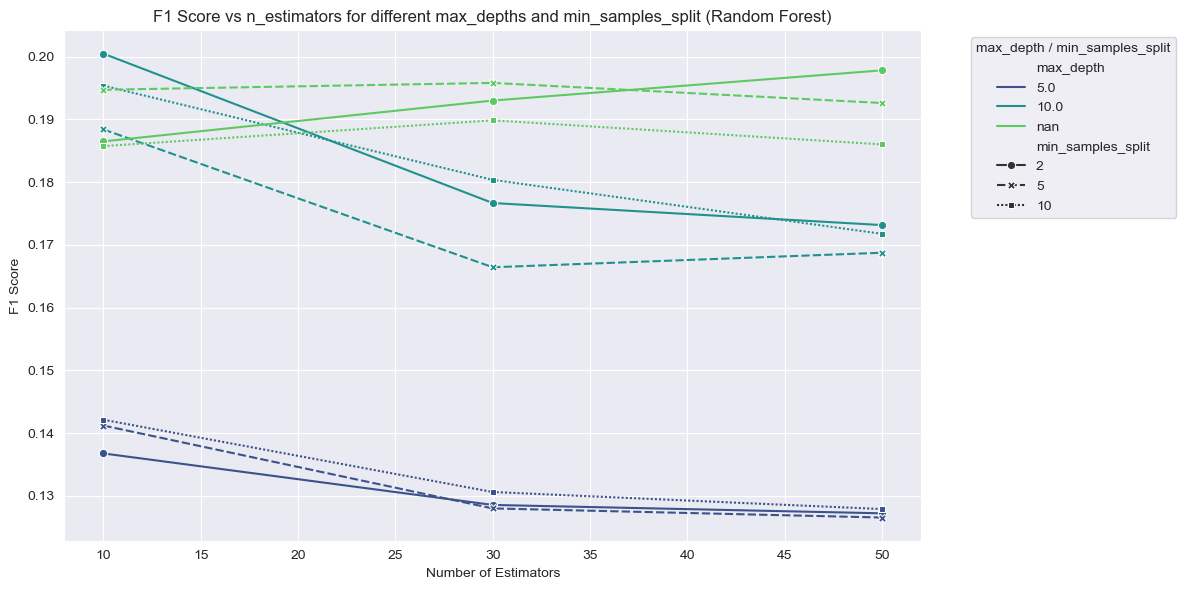

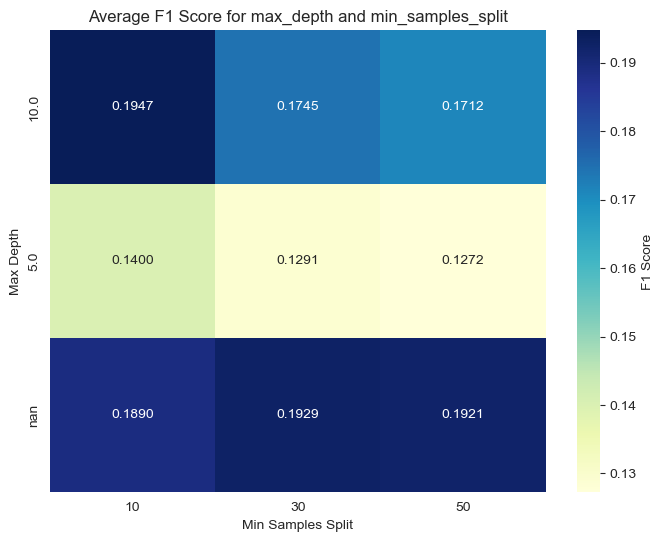

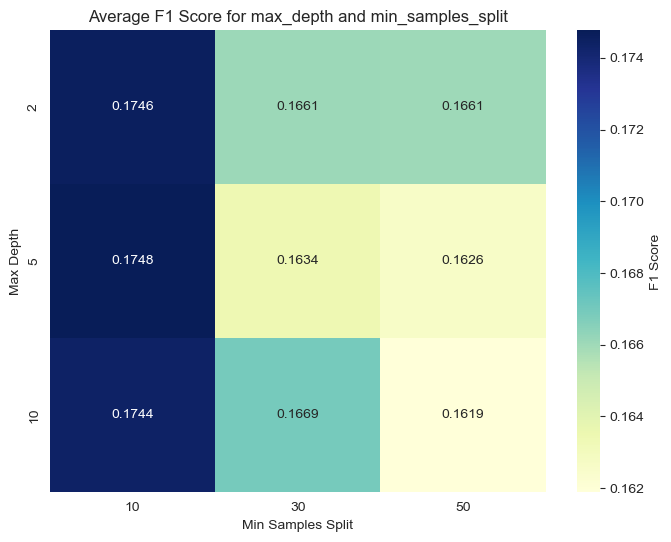

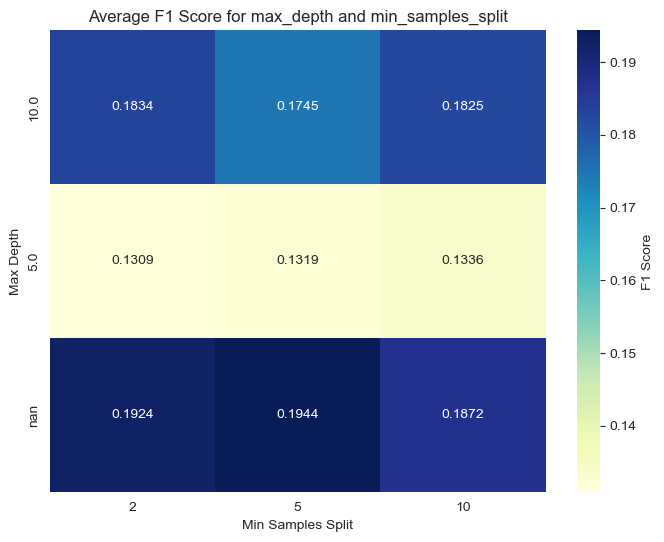

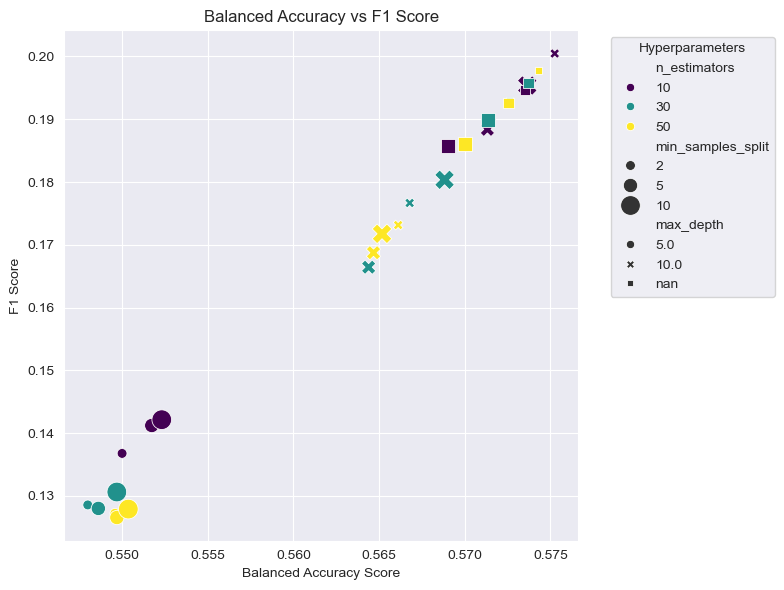

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert param_hist_rf into a DataFrame
param_hist_rf_df = pd.DataFrame(param_hist_rf)

param_hist_rf_df['max_depth'] = param_hist_rf_df['max_depth'].astype(str)


# Example 1: Plot f1_score against n_estimators for each max_depth and min_samples_split
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=param_hist_rf_df,
    x='n_estimators',
    y='f1_score',
    hue='max_depth',
    style='min_samples_split',
    markers=True,
    palette='viridis'
)
plt.title('F1 Score vs n_estimators for different max_depths and min_samples_split (Random Forest)')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.legend(title='max_depth / min_samples_split', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Example 2: Heatmap of f1_score for max_depth and min_samples_split (averaged across n_estimators)
heatmap_data = param_hist_rf_df.groupby(['max_depth', 'n_estimators'])['f1_score'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for max_depth and min_samples_split')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

heatmap_data = param_hist_rf_df.groupby(['min_samples_split', 'n_estimators'])['f1_score'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for max_depth and min_samples_split')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

heatmap_data = param_hist_rf_df.groupby(['max_depth', 'min_samples_split'])['f1_score'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for max_depth and min_samples_split')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

# Example 3: Scatter plot of Balanced Accuracy Score vs F1 Score
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=param_hist_rf_df,
    x='balanced_accuracy_score',
    y='f1_score',
    hue='n_estimators',
    style='max_depth',
    palette='viridis',
    size='min_samples_split',
    sizes=(50, 200)
)
plt.title('Balanced Accuracy vs F1 Score')
plt.xlabel('Balanced Accuracy Score')
plt.ylabel('F1 Score')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# SVM

In [31]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [3],
}
best_score = 0
best_params_svm = None
best_model_svm = None
param_hist_svm = []

for c, kernel, degree in itertools.product(
        param_grid_svm['C'],
        param_grid_svm['kernel'],
        param_grid_svm['degree']):
    # Initialize the SVM classifier
    svm = SVC(C=c, kernel=kernel, degree=degree, random_state=SEED)
    model_svm = MultiOutputClassifier(svm, n_jobs=-1)

    # Record start time
    start_time = time()
    # Fit the classifier to the training data
    model_svm.fit(X_train_hyperparam, Ys_train_hyperparam)
    # Record end time
    end_time = time()
    # Compute the training time
    training_time = end_time - start_time

    # Predict class probabilities using the best model
    Ys_prediction_val = model_svm.predict(X_val_hyperparam)

    f1_scores = []
    balanced_accuracy_scores = []
    n_labels = len(all_labels)
    for i in range(n_labels):
        if np.sum(Ys_val_hyperparam[:, i]) == 0: continue # if there is a label with no positive samples -> skip it (can be uncommented but will drag down overall score)

        f1 = f1_score(y_true=Ys_val_hyperparam[:, i], y_pred=Ys_prediction_val[:, i], zero_division=0)
        ba = balanced_accuracy_score(y_true=Ys_val_hyperparam[:, i], y_pred=Ys_prediction_val[:, i])

        f1_scores.append(f1)
        balanced_accuracy_scores.append(ba)

    # Macro-average across labels
    f1_score_macro = np.mean(f1_scores)
    balanced_accuracy_score_macro = np.mean(balanced_accuracy_scores)

    param_hist_svm.append({
        'C': c,
        'kernel': kernel,
        'degree': degree,
        'f1_score': f1_score_macro,
        'balanced_accuracy_score': balanced_accuracy_score_macro,
    })

    if f1_score_macro > best_score:
        best_score = f1_score_macro
        best_params_svm = {
            'C': c,
            'kernel': kernel,
            'degree': degree,
            'training_time': training_time,
        }
        best_model_svm = model_svm

        #with open('eval/best_params_svm.json', 'w') as f:
        #    json.dump(best_params_svm, f)
        #joblib.dump(model_svm, "eval/best_model_svm.pkl")

    print(f"Hyperparameters: C={c}, kernel={kernel}, degree={degree}")
    print(f"Macro-Averaged F1 score: {f1_score_macro}")
    print(f"Macro-Averaged Balanced Accuracy score:{balanced_accuracy_score_macro}")
    print(f"Training time: {training_time:.4f} seconds")
    print(f"--------------------------------------------------------------------------")

print("\nBest Parameters:")
print(best_params_svm)
print(f"Best f1 score: {best_score:.4f}")

Hyperparameters: C=0.1, kernel=linear, degree=3
Macro-Averaged F1 score: 0.36743854039544904
Macro-Averaged Balanced Accuracy score:0.6777369480215241
Training time: 110.0422 seconds
--------------------------------------------------------------------------
Hyperparameters: C=0.1, kernel=rbf, degree=3
Macro-Averaged F1 score: 0.37097841144721766
Macro-Averaged Balanced Accuracy score:0.6508775007944367
Training time: 416.6077 seconds
--------------------------------------------------------------------------
Hyperparameters: C=0.1, kernel=poly, degree=3
Macro-Averaged F1 score: 0.3653566368463658
Macro-Averaged Balanced Accuracy score:0.6511986223085039
Training time: 373.7257 seconds
--------------------------------------------------------------------------
Hyperparameters: C=1, kernel=linear, degree=3
Macro-Averaged F1 score: 0.3460861571847663
Macro-Averaged Balanced Accuracy score:0.6721241336277183
Training time: 92.7238 seconds
-----------------------------------------------------

In [59]:
# Manually set preferred hyperparameters
'''params_svm = {
    'C': 0.1,
    'kernel': 'linear',
    'degree': 3,
}

with open('eval/best_params_svm.json', 'w') as f:
    json.dump(params_svm, f)'''

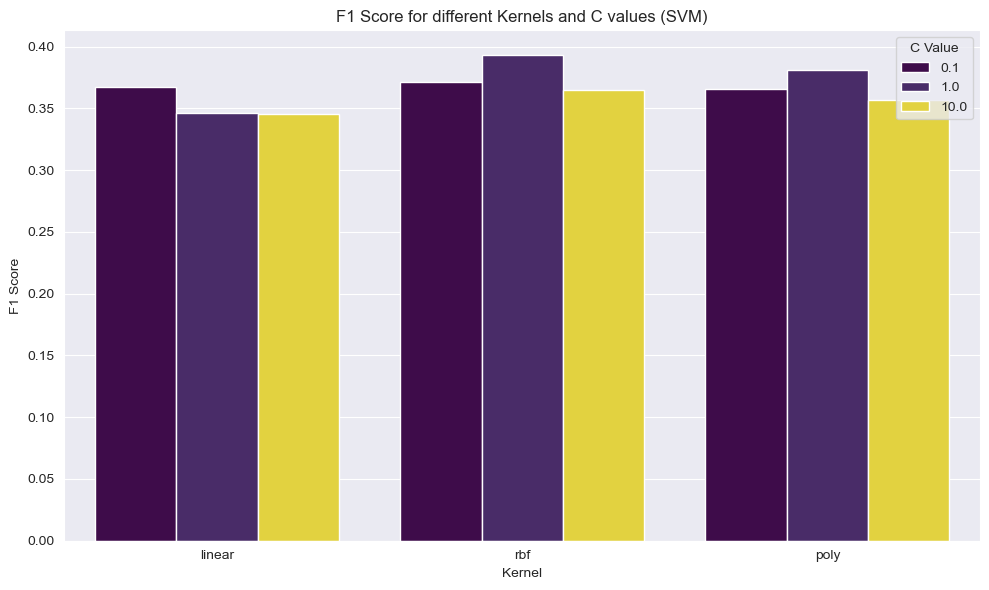

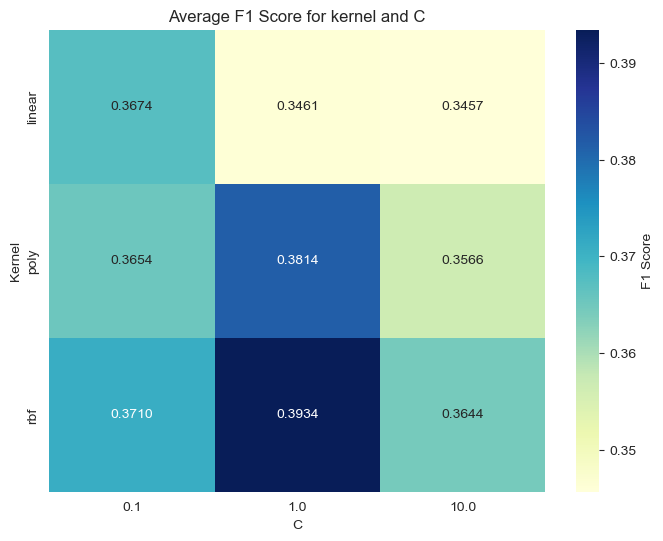

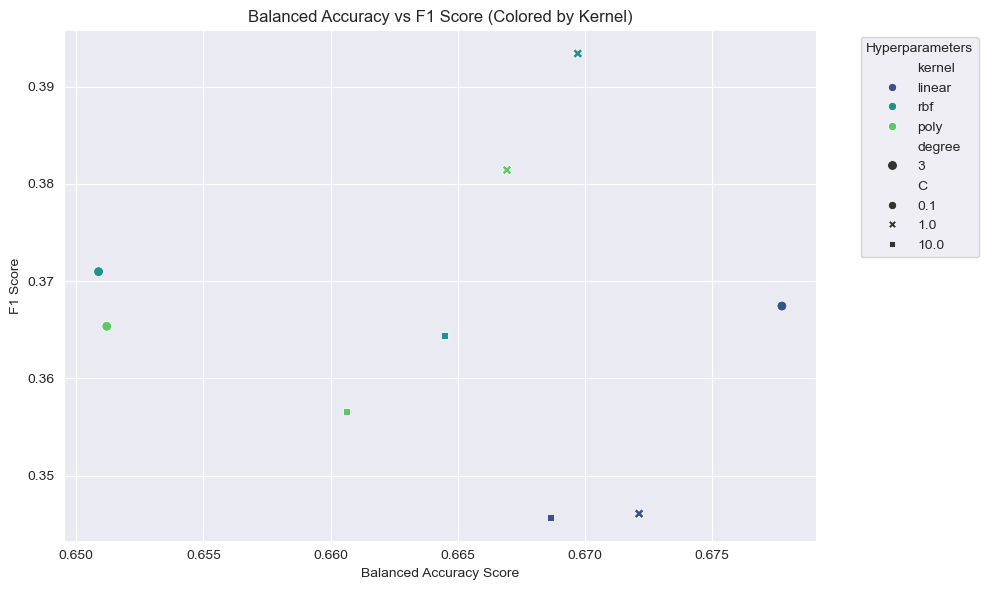

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert param_hist_svm into a DataFrame
param_hist_svm_df = pd.DataFrame(param_hist_svm)

# Example 1: Bar plot of f1_score for each kernel type.
plt.figure(figsize=(10, 6))
sns.barplot(
    data=param_hist_svm_df,
    x='kernel',
    y='f1_score',
    hue='C',
    palette='viridis',
)
plt.title('F1 Score for different Kernels and C values (SVM)')
plt.xlabel('Kernel')
plt.ylabel('F1 Score')
plt.legend(title='C Value')
plt.tight_layout()
plt.show()

# Example 2: Heatmap of f1_score for kernel and C (averaged over degree, since here it is fixed to 3)
heatmap_data = param_hist_svm_df.groupby(['kernel', 'C'])['f1_score'].mean().unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for kernel and C')
plt.xlabel('C')
plt.ylabel('Kernel')
plt.show()

# Example 3: Scatter plot of Balanced Accuracy Score vs F1 Score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=param_hist_svm_df,
    x='balanced_accuracy_score',
    y='f1_score',
    hue='kernel',
    style='C',
    palette='viridis',
    size='degree',
    sizes=(50, 200)
)
plt.title('Balanced Accuracy vs F1 Score (Colored by Kernel)')
plt.xlabel('Balanced Accuracy Score')
plt.ylabel('F1 Score')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Logistic Regression

In [18]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2', None],
    'solver': ['lbfgs', 'newton-cholesky'],

}
best_score = 0
best_params_lg = None
best_model_lr = None
param_hist_lr = []

for c, penalty, solver in itertools.product(
        param_grid_lr['C'],
        param_grid_lr['penalty'],
        param_grid_lr['solver']):
    # Initialize the Logistic Regression classifier
    lr = LogisticRegression(C=c, penalty=penalty, solver=solver, random_state=SEED)
    model_lr = MultiOutputClassifier(lr, n_jobs=-1)

    # Record start time
    start_time = time()
    # Fit the classifier to the training data
    model_lr.fit(X_train_hyperparam, Ys_train_hyperparam)
    # Record end time
    end_time = time()
    # Compute the training time
    training_time = end_time - start_time

    # Predict class probabilities using the best model
    Ys_prediction_val = model_lr.predict(X_val_hyperparam)

    f1_scores = []
    balanced_accuracy_scores = []
    n_labels = len(all_labels)
    for i in range(n_labels):
        if np.sum(Ys_val_hyperparam[:, i]) == 0: continue # if there is a label with no positive samples -> skip it (can be uncommented but will drag down overall score)

        f1 = f1_score(y_true=Ys_val_hyperparam[:, i], y_pred=Ys_prediction_val[:, i], zero_division=0)
        ba = balanced_accuracy_score(y_true=Ys_val_hyperparam[:, i], y_pred=Ys_prediction_val[:, i])

        f1_scores.append(f1)
        balanced_accuracy_scores.append(ba)

    # Macro-average across labels
    f1_score_macro = np.mean(f1_scores)
    balanced_accuracy_score_macro = np.mean(balanced_accuracy_scores)

    param_hist_lr.append({
    'C': c,
    'penalty': penalty,
    'solver': solver,
    'f1_score': f1_score_macro,
    'balanced_accuracy_score': balanced_accuracy_score_macro,
    })

    if f1_score_macro > best_score:
        best_score = f1_score_macro
        best_params_lg = {
            'C': c,
            'penalty': penalty,
            'solver': solver,
            'training_time': training_time,
        }
        best_model_lr = model_lr

        #with open('eval/best_params_lr.json', 'w') as f:
        #    json.dump(best_params_lr, f)
        #joblib.dump(model_lr, "eval/best_model_lr.pkl")

    print(f"Hyperparameters: C={c}, penalty={penalty}, solver={solver}")
    print(f"Macro-Averaged F1 score: {f1_score_macro}")
    print(f"Macro-Averaged Balanced Accuracy score:{balanced_accuracy_score_macro}")
    print(f"Training time: {training_time:.4f} seconds")
    print(f"--------------------------------------------------------------------------")

print("\nBest Parameters:")
print(best_params_lg)
print(f"Best f1 score: {best_score:.4f}")



Hyperparameters: C=0.001, penalty=l2, solver=lbfgs
Macro-Averaged F1 score: 0.35749175757651375
Macro-Averaged Balanced Accuracy score:0.6436640700903536
Training time: 42.0659 seconds
--------------------------------------------------------------------------
Hyperparameters: C=0.001, penalty=l2, solver=newton-cholesky
Macro-Averaged F1 score: 0.35759430415275667
Macro-Averaged Balanced Accuracy score:0.6436907552426694
Training time: 164.7033 seconds
--------------------------------------------------------------------------
Hyperparameters: C=0.001, penalty=None, solver=lbfgs
Macro-Averaged F1 score: 0.35142764814463245
Macro-Averaged Balanced Accuracy score:0.6639039244390801
Training time: 31.8223 seconds
--------------------------------------------------------------------------
Hyperparameters: C=0.001, penalty=None, solver=newton-cholesky
Macro-Averaged F1 score: 0.35142764814463245
Macro-Averaged Balanced Accuracy score:0.6639039244390801
Training time: 56.7393 seconds
----------

In [ ]:
# Manually set preferred hyperparameters
'''params_lr = {
    'C': 10,
    'penalty': 10,
    'solver': 5,
}

with open('eval/best_params_rf.json', 'w') as f:
    json.dump(params_lg, f)'''

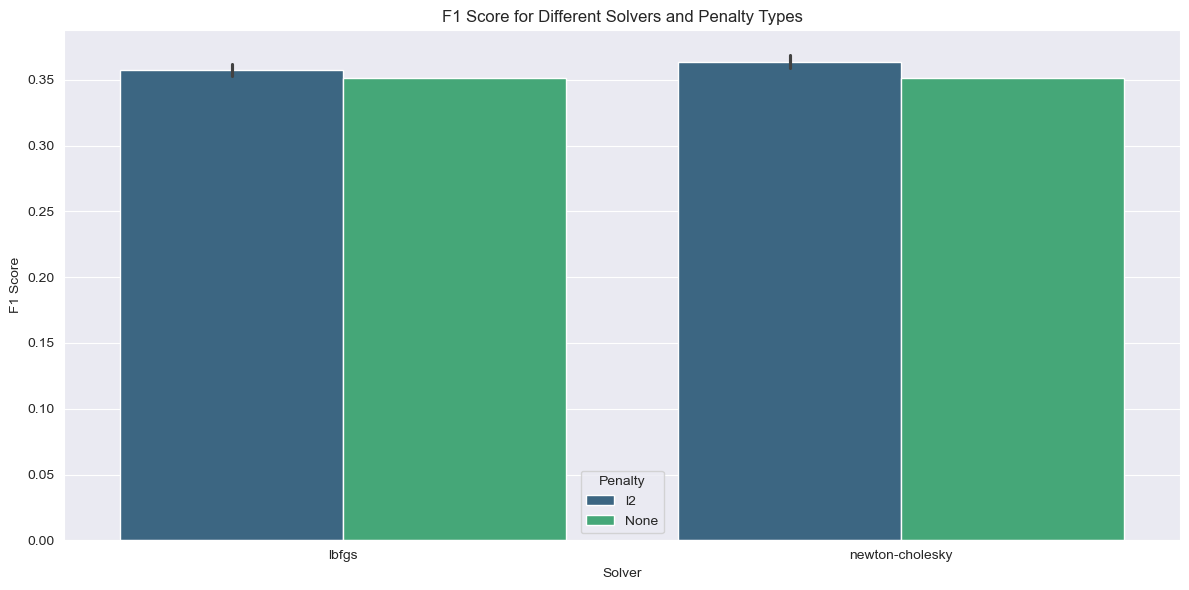

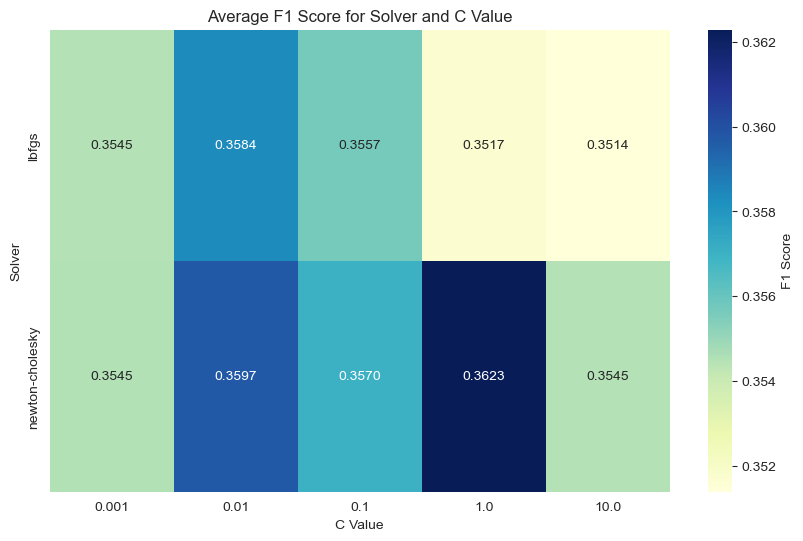

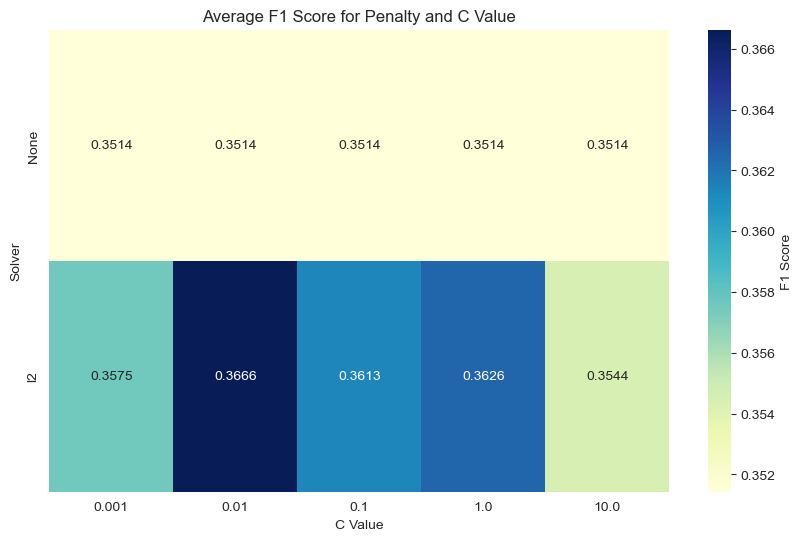

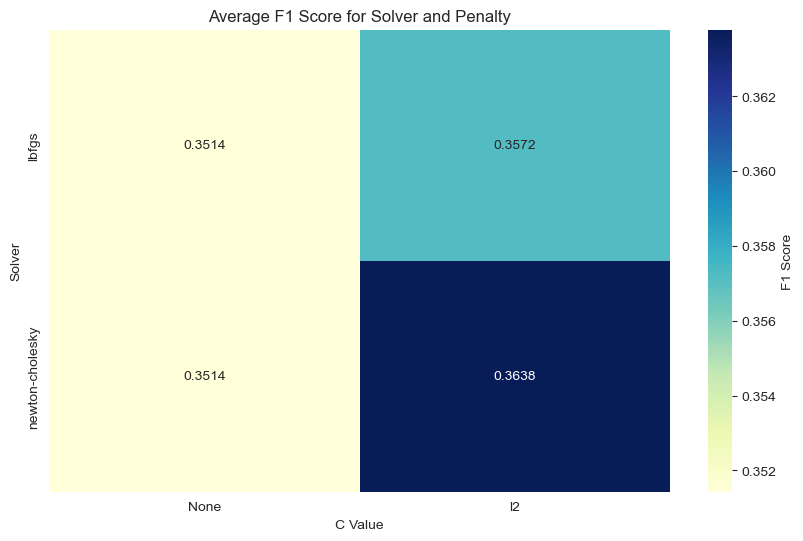

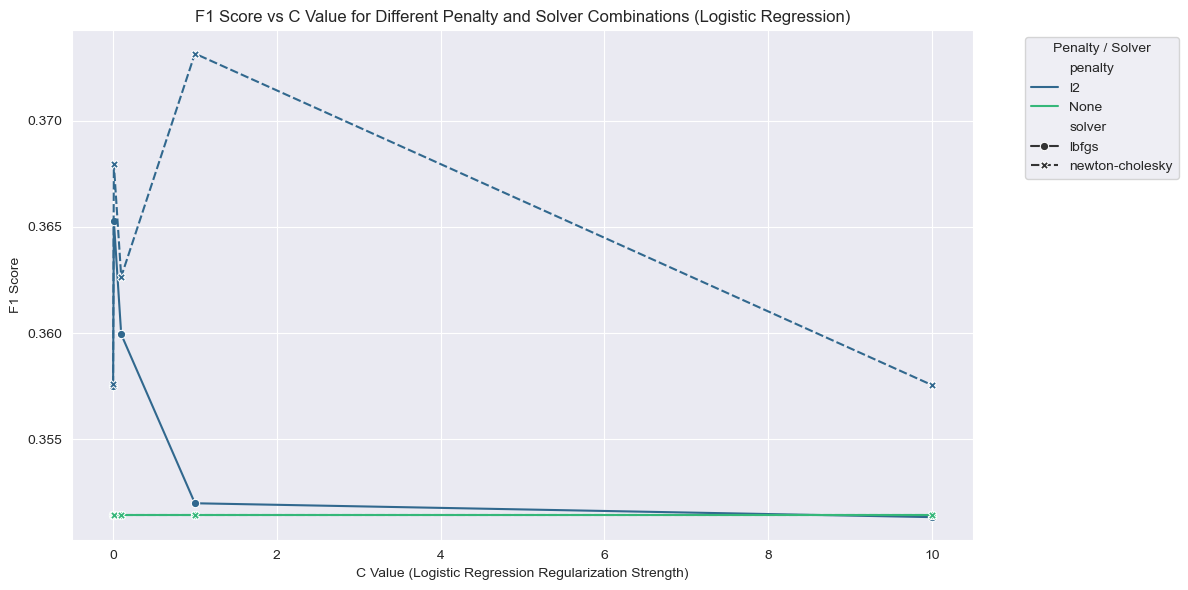

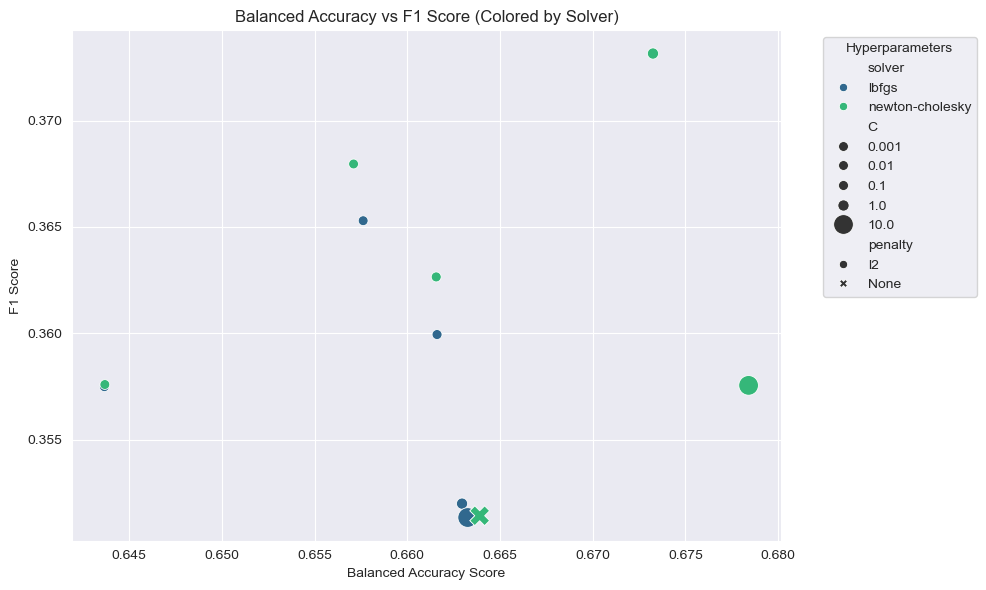

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert param_hist_lr into a DataFrame
param_hist_lr_df = pd.DataFrame(param_hist_lr)

param_hist_lr_df['penalty'] = param_hist_lr_df['penalty'].astype(str)

# Example 1: Bar plot for F1 Score with different solvers and penalties
plt.figure(figsize=(12, 6))
sns.barplot(
    data=param_hist_lr_df,
    x='solver',
    y='f1_score',
    hue='penalty',
    palette='viridis',
)
plt.title('F1 Score for Different Solvers and Penalty Types')
plt.xlabel('Solver')
plt.ylabel('F1 Score')
plt.legend(title='Penalty')
plt.tight_layout()
plt.show()

# Example 2: Heatmap of F1 Score for C and Solver (averaged across penalty types)
heatmap_data = param_hist_lr_df.groupby(['solver', 'C'])['f1_score'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for Solver and C Value')
plt.xlabel('C Value')
plt.ylabel('Solver')
plt.show()

heatmap_data = param_hist_lr_df.groupby(['penalty', 'C'])['f1_score'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for Penalty and C Value')
plt.xlabel('C Value')
plt.ylabel('Solver')
plt.show()

heatmap_data = param_hist_lr_df.groupby(['solver', 'penalty'])['f1_score'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1 Score'}
)
plt.title('Average F1 Score for Solver and Penalty')
plt.xlabel('C Value')
plt.ylabel('Solver')
plt.show()

# Example 3: Line plot of F1 Score vs C for penalty and solver
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=param_hist_lr_df,
    x='C',
    y='f1_score',
    hue='penalty',
    style='solver',
    markers=True,
    palette='viridis',
)
plt.title('F1 Score vs C Value for Different Penalty and Solver Combinations (Logistic Regression)')
plt.xlabel('C Value (Logistic Regression Regularization Strength)')
plt.ylabel('F1 Score')
plt.legend(title='Penalty / Solver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Example 4: Scatter plot for Balanced Accuracy Score vs F1 Score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=param_hist_lr_df,
    x='balanced_accuracy_score',
    y='f1_score',
    hue='solver',
    style='penalty',
    palette='viridis',
    size='C',
    sizes=(50, 200)
)
plt.title('Balanced Accuracy vs F1 Score (Colored by Solver)')
plt.xlabel('Balanced Accuracy Score')
plt.ylabel('F1 Score')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Train final Models

In [17]:
# Take subset of Dataset for final training
train_percentage = 0.25
X_train_final = X_train[:int(train_percentage * len(X_train))]
X_train_final = np.insert(X_train_final, 0, np.zeros(X_train_final.shape[1]), axis=0)
X_train_final = np.insert(X_train_final, 0, np.ones(X_train_final.shape[1]), axis=0)
Ys_train_final = Ys_train[:int(train_percentage * len(Ys_train))]
Ys_train_final = np.insert(Ys_train_final, 0, np.zeros(Ys_train_final.shape[1]), axis=0)
Ys_train_final = np.insert(Ys_train_final, 0, np.ones(Ys_train_final.shape[1]), axis=0)
X_val_final = X_val[:int(train_percentage * len(X_val))]
Ys_val_final = Ys_val[:int(train_percentage * len(Ys_val))]
X_test_final = X_test[:int(train_percentage * len(X_test))]
Ys_test_final = Ys_test[:int(train_percentage * len(Ys_test))]

print("Train, test and validation set sizes for final training:")
print(f"-Train: {len(X_train_final)}")
print(f"-Test: {len(X_test_final)}")
print(f"-Validation: {len(X_val_final)}")

Train, test and validation set sizes for final training:
-Train: 230510
-Test: 77127
-Validation: 77008


In [19]:
def train_final_model(param_grid, classifier='LR'):
    if classifier == 'RF':
        n_estimators = param_grid['n_estimators']
        max_depth = param_grid['max_depth']
        min_samples_split = param_grid['min_samples_split']

        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=SEED)
        model = MultiOutputClassifier(clf, n_jobs=2)

    elif classifier == 'SVM':
        c = param_grid['C']
        kernel = param_grid['kernel']
        degree = param_grid['degree']

        clf = SVC(C=c, kernel=kernel, degree=degree, random_state=SEED)
        model = MultiOutputClassifier(clf, n_jobs=2)

    elif classifier == 'LR':
        c = param_grid['C']
        penalty = param_grid['penalty']
        solver = param_grid['solver']

        clf = LogisticRegression(C=c, penalty=penalty, solver=solver, max_iter=1000, random_state=SEED)
        model = MultiOutputClassifier(clf, n_jobs=2)

    else:
        raise KeyError("Invalid classifier name. Please choose one of 'RF', 'SVM', 'LG'.")

    # Record start time
    start_time = time()
    # Fit the classifier to the training data
    model.fit(X_train_final, Ys_train_final)
    # Record end time
    end_time = time()
    # Compute the training time
    training_time = end_time - start_time

    # Predict class probabilities using the best model
    Ys_prediction_test = model.predict(X_test_final)

    f1_scores = []
    balanced_accuracy_scores = []
    n_labels = len(all_labels)
    for i in range(n_labels):
        if np.sum(Ys_test_final[:, i]) == 0: continue # if there is a label with no positive samples -> skip it (can be uncommented but will drag down overall score)

        f1 = f1_score(y_true=Ys_test_final[:, i], y_pred=Ys_prediction_test[:, i], zero_division=0)
        ba = balanced_accuracy_score(y_true=Ys_test_final[:, i], y_pred=Ys_prediction_test[:, i])

        f1_scores.append(f1)
        balanced_accuracy_scores.append(ba)

    # Macro-average across labels
    f1_score_macro = np.mean(f1_scores)
    balanced_accuracy_score_macro = np.mean(balanced_accuracy_scores)

    if classifier == 'RF':
        joblib.dump(model, "eval/best_model_rf.pkl")

        print(f"Hyperparameters: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}")
        print(f"Macro-Averaged F1 score: {f1_score_macro}")
        print(f"Macro-Averaged Balanced Accuracy score:{balanced_accuracy_score_macro}")
        print(f"Training time: {training_time:.4f} seconds")
        print(f"--------------------------------------------------------------------------")

    elif classifier == 'SVM':
        joblib.dump(model, "eval/best_model_svm.pkl")

        print(f"Hyperparameters: C={c}, kernel={kernel}, degree={degree}")
        print(f"Macro-Averaged F1 score: {f1_score_macro}")
        print(f"Macro-Averaged Balanced Accuracy score:{balanced_accuracy_score_macro}")
        print(f"Training time: {training_time:.4f} seconds")
        print(f"--------------------------------------------------------------------------")

    elif classifier == 'LR':
        joblib.dump(model, "eval/best_model_lr.pkl")

        print(f"Hyperparameters: C={c}, penalty={penalty}, solver={solver}")
        print(f"Macro-Averaged F1 score: {f1_score_macro}")
        print(f"Macro-Averaged Balanced Accuracy score:{balanced_accuracy_score_macro}")
        print(f"Training time: {training_time:.4f} seconds")
        print(f"--------------------------------------------------------------------------")





In [64]:
with open('eval/best_params_rf.json', 'r') as f:
    best_params_rf = json.load(f)

train_final_model(best_params_rf, classifier='RF')

Hyperparameters: n_estimators=10, max_depth=10, min_samples_split=5
Macro-Averaged F1 score: 0.32175789300957464
Macro-Averaged Balanced Accuracy score:0.6174237429453017
Training time: 2409.4897 seconds
--------------------------------------------------------------------------


In [20]:
with open('eval/best_params_svm.json', 'r') as f:
    best_params_svm = json.load(f)

train_final_model(best_params_svm, classifier='SVM')

Hyperparameters: C=0.1, kernel=linear, degree=3
Macro-Averaged F1 score: 0.45655198997678076
Macro-Averaged Balanced Accuracy score:0.7236830805008045
Training time: 17754.8316 seconds
--------------------------------------------------------------------------


In [31]:
with open('eval/best_params_lr.json', 'r') as f:
    best_params_lr = json.load(f)

train_final_model(best_params_lr, classifier='LR')

Hyperparameters: C=0.1, penalty=l2, solver=lbfgs
Macro-Averaged F1 score: 0.5460769902396615
Macro-Averaged Balanced Accuracy score:0.758768922996522
Training time: 6487.1182 seconds
--------------------------------------------------------------------------


# CNN

In [21]:
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]  # Feature tensor
        y = self.labels[idx]    # Label tensor
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_dataset = AudioDataset(X_train_final, Ys_train_final)
val_dataset = AudioDataset(X_val_final, Ys_val_final)
test_dataset = AudioDataset(X_test_final, Ys_test_final)


In [27]:
class AudioCNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioCNNClassifier, self).__init__()

        # Define 1D Convolutional Layers with Batch Norm
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)  # Output: (32, 871)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)  # Output: (64, 871)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output: (128, 871)
        self.bn3 = nn.BatchNorm1d(128)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Halves sequence length
        self.dropout = nn.Dropout(0.5)  # Regularization

        # Fully Connected Layers
        conv_output_size = input_size // 4  # After 2 max pooling layers
        self.fc1 = nn.Linear(128 * conv_output_size, 256)  # Dense layer
        self.fc2 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        # Input shape: (batch_size, 1, 871)

        # Convolutional Layer 1 with Batch Norm + Activation
        x = F.relu(self.bn1(self.conv1(x)))

        # Convolutional Layer 2 with Batch Norm + Pooling + Activation
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Convolutional Layer 3 with Batch Norm + Pooling + Activation
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.dropout(x)  # Dropout regularization
        x = x.view(x.size(0), -1)  # Flatten to feed FC layers

        # Fully Connected Layers
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        logits = self.fc2(x)  # Fully Connected Layer 2 (logits)
        return logits  # Raw logits for BCEWithLogitsLoss

In [28]:



def compute_class_weights(dataset):
    # Assumes `dataset` provides labels as a 2D tensor (num_samples x num_classes)
    all_labels = torch.cat([labels for _, labels in DataLoader(dataset, batch_size=32)], dim=0).cpu().numpy()
    num_classes = all_labels.shape[1]

    # Compute class weights for each class
    class_weights = []
    for class_idx in range(num_classes):
        class_weights.append(compute_class_weight('balanced', classes=np.array([0, 1]), y=all_labels[:, class_idx]))

    # Convert to tensor
    pos_weight = torch.tensor([weights[1] for weights in class_weights], dtype=torch.float32)
    return pos_weight


def training_loop(
        model: torch.nn.Module,
        train_data: torch.utils.data.Dataset,
        val_data: torch.utils.data.Dataset,
        test_data: torch.utils.data.Dataset,
        max_epochs: int = 1000,
        batch_size: int = 32,
        learning_rate: float = 1e-3,
        patience: int = 3,
        show_progress: bool = True,
):
    # Set device
    if torch.cuda.is_available():
        print("CUDA is available. PyTorch will use the GPU.")
        print(f"CUDA version: {torch.version.cuda}")
        device = torch.device("cuda")
    else:
        print("CUDA is NOT available. PyTorch will use the CPU.")
        device = torch.device("cpu")

    model.to(device)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    # Compute class weights based on the training dataset
    pos_weight = compute_class_weights(train_data).to(device)

    # Define loss function with class weights
    loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.05)


    train_losses = []
    val_losses = []
    dynamic_thresholds = None

    for epoch in tqdm(range(max_epochs)) if show_progress else range(max_epochs):
        # Training step
        model.train()
        total_train_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device).unsqueeze(1).float()
            labels = labels.to(device).float()

            # Forward pass
            logits = model(inputs)
            logits.to(device)
            train_loss = loss_function(logits, labels)


            total_train_loss += train_loss.item()

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            optimizer.step()

        # Average train loss
        train_loss_avg = total_train_loss / len(train_loader)
        train_losses.append(train_loss_avg)


        # Validation step
        model.eval()
        total_val_loss = 0.0
        num_correct = 0
        num_total = 0

        all_predictions = []
        all_true_labels = []
        all_logits = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).unsqueeze(1).float()
                labels = labels.to(device).float()

                # Forward pass
                logits = model(inputs)
                logits.to(device)
                val_loss = loss_function(logits, labels)
                total_val_loss += val_loss.item()

                # Save logits and labels for threshold computation
                all_logits.append(torch.sigmoid(logits).cpu().numpy())  # Apply sigmoid but don't threshold yet
                all_true_labels.append(labels.cpu().numpy())


        val_loss_avg = total_val_loss / len(val_loader)
        val_losses.append(val_loss_avg)

        # Concatenate all logits and true labels for threshold computation
        all_logits = np.concatenate(all_logits, axis=0)  # Shape: (num_samples, num_classes)
        all_true_labels = np.concatenate(all_true_labels, axis=0)  # Shape: (num_samples, num_classes)

        # Compute class-wise optimal thresholds from validation set
        thresholds = []
        for class_idx in range(all_true_labels.shape[1]):
            fpr, tpr, thresh = roc_curve(all_true_labels[:, class_idx], all_logits[:, class_idx])
            optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
            thresholds.append(thresh[optimal_idx])

        dynamic_thresholds = np.array(thresholds)  # Save for later use

        # Apply dynamic thresholds to calculate validation accuracy and F1 score
        val_predictions = all_logits > dynamic_thresholds  # Threshold each class accordingly
        num_correct = (val_predictions == all_true_labels).sum()
        num_total = all_true_labels.size
        val_accuracy = 100 * num_correct / num_total


        scheduler.step(val_loss_avg)


        # Calculate the F1 score (macro-averaged for multi-label)
        val_f1_score = f1_score(all_true_labels, val_predictions, average='macro', zero_division=0)

        # Print metrics for this epoch
        print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Val F1 Score: {val_f1_score:.4f}")



        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            torch.save(model.state_dict(), 'eval/best_model_cnn.pth')  # Save best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


    # Load best model for testing
    model.load_state_dict(torch.load('eval/best_model.pth'))
    model.eval()

    # Test set evaluation
    num_correct = 0
    num_total = 0
    all_predictions = []
    all_true_labels = []
    all_logits = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).unsqueeze(1).float()
            labels = labels.to(device).float()
            logits = model(inputs)
            all_logits.append(torch.sigmoid(logits).cpu().numpy())
            all_true_labels.append(labels.cpu().numpy())


    all_logits = np.concatenate(all_logits, axis=0)  # raw sigmoid outputs
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    # Apply dynamic thresholds
    test_predictions = all_logits > dynamic_thresholds  # Use precomputed thresholds
    num_correct = (test_predictions == all_true_labels).sum()
    num_total = all_true_labels.size
    test_accuracy = 100 * num_correct / num_total


    # Calculate the F1 score (macro-averaged for multi-label)
    val_f1_score = f1_score(all_true_labels, test_predictions, average='macro', zero_division=0)

    test_accuracy = 100 * num_correct / num_total
    print(f"Test Accuracy: {test_accuracy:.2f}%, "
          f"Test F1 Score: {val_f1_score:.4f}")

    return train_losses, val_losses

def plot_losses(train_losses, eval_losses):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure with size
    ax.set_title("Training and Validation Loss over Epochs")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)

    # Directly use the `train_losses` and `eval_losses` lists if they are floats
    ax.plot(train_losses, label="Training Loss")
    ax.plot(eval_losses, label="Validation Loss")

    # Show the legend and plot
    ax.legend()
    plt.show()


model = AudioCNNClassifier(input_size=871, num_classes=len(all_labels))
train_losses, eval_losses = training_loop(model, train_dataset, val_dataset, test_dataset,
                                          max_epochs=100,
                                          learning_rate=1e-3,
                                          patience=5,
                                          batch_size=16,
                                          show_progress=True)

plot_losses(train_losses, eval_losses)

CUDA is available. PyTorch will use the GPU.
CUDA version: 12.4


  1%|          | 1/100 [04:49<7:56:56, 289.05s/it]

Epoch [1/100], Train Loss: 0.2586, Val Loss: 0.5064, Val Accuracy: 90.93%, Val F1 Score: 0.2763


  2%|▏         | 2/100 [09:29<7:44:15, 284.24s/it]

Epoch [2/100], Train Loss: 0.2425, Val Loss: 0.5616, Val Accuracy: 90.43%, Val F1 Score: 0.2756


  2%|▏         | 2/100 [09:54<8:05:08, 297.02s/it]


KeyboardInterrupt: 